#**CHAPTER 10. SYSTEMIC STRESS**
---

##0.REFERENCE

https://chatgpt.com/share/698b2a42-71c8-8012-9bd9-710f682bfe3c

##1.CONTEXT

**Introduction (Chapter 10 — Systemic Stress: Cascade Simulator)**

This chapter is built around a simple but professionally inconvenient claim: in systemic episodes, markets do not primarily move because beliefs change; they move because balance sheets break. The laboratory you are about to run is not a model of “value,” and it is not a model of “forecasting.” It is a controlled mechanism experiment in which the dominant causal chain is mechanical: leverage creates fragility, fragility creates forced selling, forced selling creates price impact, and price impact feeds back into balance sheets. The point is to make visible, with synthetic data and explicit constraints, why the difference between an elegant strategy and a survivable strategy is often the execution of de-risking under stress.

The chapter’s organizing principle is mechanism-first design. Rather than starting with a predictive signal and then layering realism, the notebook starts with the institutional structure that determines feasibility. A portfolio is not an abstract vector of weights; it is an inventory held on a funding stack and monitored by margin rules. A “market” is not a random walk; it is an arena in which many participants share collateral constraints and transmit losses through overlapping exposures. In calm regimes, these facts remain in the background. In stress regimes, they become the market. This notebook makes that inversion explicit: optimization is allowed only until constraints bind, at which point survival logic takes precedence.

The tradable object in this chapter is intentionally not a yield curve or an implied-vol surface. It is a balance-sheet surface: a network exposure graph, represented as an adjacency matrix, paired with a distress vector and an aggregate cascade-pressure scalar. This is a deliberate conceptual move. In systemic events, what becomes “priced” is not only cash flows and discount rates; it is the ability to finance risk. The exposure graph is tradable in the sense that it governs the mapping from shocks to forced liquidations, and thus it governs the marginal cost of holding or changing inventory. When the network is tightly coupled, idiosyncratic losses become systemic. When the network is sparse, the same shock can be absorbed locally. The surface is not a descriptive statistic; it is the mechanism that determines the geometry of contagion.

A core pedagogical objective is to break the habit of narrating crises as if they were primarily about sentiment. Sentiment matters, but it matters most as an amplifier of the funding channel: higher risk aversion raises haircuts, tighter margin increases liquidation propensity, and rising funding spreads compress the time available to adjust positions. The notebook represents these elements as explicit state variables that evolve with regime: funding stress, margin tightness, and a risk-aversion proxy. These variables do not exist for realism alone; they exist to make causal explanation possible. When you observe a drawdown, you can point to a specific, logged mechanism—rising cascade pressure, rising forced sales, higher impact, and binding leverage—rather than treating losses as unexplained noise.

The regime structure is not an aesthetic choice. It is a formal way to express that markets exhibit phases in which constraints are slack and phases in which constraints dominate. The Markov regime process drives changes in volatility, funding conditions, and the severity of impact. In calm states, recovery forces rebuild buffers and leverage drifts down, illustrating that balance sheets are not static. In transition and stress, those stabilizers weaken: leverage can rise mechanically as equity shrinks, distress propagates through exposures, and forced sales become larger and more synchronized. The result is a laboratory environment in which the same position can be safe in one regime and fatal in another, even if the expected drift of prices is unchanged. This is one of the central lessons of systemic trading: the state variable is the feasibility of risk, not the direction of returns.

A second objective is to demonstrate why execution is not a footnote. The notebook includes transaction costs and a slippage/impact proxy that increases with systemic pressure. This is an implementation of a well-known institutional asymmetry: liquidity is most available when you do not need it, and least available when you do. When cascade pressure is low, adjusting risk posture is relatively cheap; when cascade pressure spikes, the marginal cost of trading increases sharply. This is not merely punitive; it is the economic content of the chapter. In a frictionless world, the correct response to stress is always “just hedge.” In a world with endogenous impact, hedging and exiting compete with survival by consuming equity through costs. Students should come away understanding that the cost of changing positions is part of the risk of holding positions.

The agentic layer is included to make decision-making a constrained engineering problem rather than a storytelling exercise. The action space is intentionally finite: `DELEVER`, `HOLD`, `EMERGENCY_EXIT`. This constraint is not an artificial simplification; it is a faithful abstraction of institutional posture choices. In crises, most strategies collapse into a small set of behaviors: reduce gross, maintain, or cut risk aggressively. The baseline policy encodes auditable thresholds on cascade pressure and funding/margin conditions, representing rule-based risk management. The optional LLM policy exists not to “beat” the baseline but to test whether a constrained reasoning module can select postures in a way that remains execution-aware and governance-compliant. The LLM is boxed: it sees only compact summaries and must return machine-parseable JSON selecting one allowed action with a short rationale. It cannot modify code, cannot invent trades, and cannot access parameters. If it violates the contract, the system falls back to the baseline automatically.

This governance-first approach to agent integration is itself a lesson. A system that behaves well in calm conditions but fails under stress is not robust; it is fragile by design. The notebook logs every step—state summary, action, rationale, executed trade, costs, leverage usage, and incremental PnL—so that outcomes can be traced back to causes. The telemetry is not decoration; it is the mechanism’s audit trail. Without it, the experiment would invite post hoc narratives. With it, the experiment becomes falsifiable: you can test whether de-risking decisions occurred before or after cascade pressure spikes, whether costs dominated the drawdown, and whether leverage constraints forced behavior.

The diagnostics produced at the end are chosen to support structural interpretation rather than performance celebration. The equity curve shows not only returns but constraint binding and recovery. The regime plot anchors outcomes in state changes. The cumulative cost plot quantifies the execution tax paid for survival. Action counts show whether the policy is stable or thrashes under noise. Summary metrics provide compact comparisons across parameter variants, but the centerpiece is the interpretive table that maps mechanism to observation to fragility to execution note. This table formalizes what practitioners learn the hard way: the “edge” in systemic trading is often the disciplined management of inventory and financing under adverse feedback loops.

Ultimately, Chapter 10 is the capstone stress test of the entire mechanism-first philosophy. Earlier chapters can make markets look clean: yield curves, carry surfaces, volatility tensors, and correlation matrices are tradable objects that reward certain postures under certain regimes. This chapter shows what happens when the common assumption behind all of them fails: that you can always adjust positions at tolerable cost before constraints bind. In the cascade laboratory, the market is not a passive environment; it is a coupled system in which the act of de-risking is itself a source of losses, and the network structure determines whether shocks remain local or become systemic. If you remember one sentence after running the notebook, it should be this: in cascades, survival dominates optimization, and the primary object of trading is not price—it is balance-sheet feasibility.


##2.LIBRARIES AND ENVIRONMENT

In [8]:
# CELL 2 — Code
# Setup: imports, seed, run_config, utilities, logging scaffolding

import os, time, json, math, hashlib, platform, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Any, List, Optional, Tuple

def stable_hash(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()[:16]

def env_fingerprint() -> Dict[str, str]:
    return {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "numpy": np.__version__,
        "pandas": pd.__version__,
    }

# ----------------------------
# RUN CONFIG (reproducible)
# ----------------------------
run_config = {
    "chapter_id": 10,
    "chapter_name": "Systemic Stress — Cascade Simulator",
    "seed": 10,
    "T": 100,
    "dt": 1.0,

    "regimes": {
        "names": ["calm", "transition", "stress"],
        "markov_P": [
            [0.965, 0.030, 0.005],
            [0.060, 0.900, 0.040],
            [0.030, 0.120, 0.850],
        ],
        "notes": "Regime drives funding stress, margin tightness, and impact severity."
    },

    "market_params": {
        "mechanism": "balance-sheet constraints + funding stress + network contagion → forced sales → price impact feedback",
        "N_institutions": 18,
        "base_drift": 0.0002,
        "base_vol": 0.010,
        "stress_vol_mult": 2.8,
        "impact_kappa": 0.18,         # price impact per unit forced sale pressure
        "contagion_alpha": 0.35,      # how much network losses amplify distress
        "recovery_speed": 0.06,       # how quickly institutions rebuild buffers in calm
    },

    "surface_params": {
        "surface_type": "matrix+vector",
        "construction": "adjacency exposure matrix W (institution→institution) + distress vector d_t + cascade pressure scalar",
        "notes": "The 'surface' is tradable because it prices *transitions* (rebalancing) through stress-dependent impact and constraints."
    },

    "execution_params": {
        "cost_fixed": 0.0,
        "cost_bps": 1.5,
        "slippage_lambda": 0.22,
        "impact_proxy": "abs(trade) * slippage_lambda * (1 + 6*cascade_pressure)"
    },

    "risk_params": {
        "max_leverage": 2.0,
        "pos_limit": 1.25,        # |position| ≤ pos_limit (units of risk asset exposure)
        "max_dd_stop": 0.25
    },

    "policy_params": {
        "enable_llm": True,
        "llm_model": "gpt-4o-mini",
        "llm_temperature": 0.0,
        "fallback_to_baseline_on_error": True,
        "decision_interval": 1,   # call LLM every step (set >1 if you want fewer calls)
        "max_rationale_chars": 240
    }
}

np.random.seed(run_config["seed"])

# ----------------------------
# Audit artifacts (lightweight)
# ----------------------------
run_manifest = {
    "run_id": stable_hash(json.dumps({"t": time.time(), "seed": run_config["seed"]}, sort_keys=True)),
    "run_config": run_config,
    "config_hash": stable_hash(json.dumps(run_config, sort_keys=True)),
    "env": env_fingerprint(),
    "timestamp_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "verification_status": "Not verified"
}

print("RUN MANIFEST (summary):")
print(json.dumps({k: run_manifest[k] for k in ["run_id","config_hash","timestamp_utc","verification_status"]}, indent=2))

# In-memory logs (single source of truth)
step_logs: List[Dict[str, Any]] = []
llm_telemetry: List[Dict[str, Any]] = []

# Convenience: action enum (enforced in Cell 6)
ACTIONS = ["DELEVER", "HOLD", "EMERGENCY_EXIT"]


RUN MANIFEST (summary):
{
  "run_id": "b1bfd947bdfcfb85",
  "config_hash": "d2ef78c286924ceb",
  "timestamp_utc": "2026-02-10T12:28:57Z",
  "verification_status": "Not verified"
}


##3.REGIME PROCESS

###3.1.OVERVIEW

**Cell 3 — Regime process and cross-asset state evolution**

This cell establishes the *exogenous* driver of the laboratory: a discrete regime process that governs macro coupling. The purpose is to make “risk-on / risk-off” not a narrative label but a **state variable** that evolves according to an explicit Markov transition matrix. In this chapter, the central economic mechanism is that *the strength of a latent common factor is regime-dependent*: when stress arrives, cross-asset correlations rise, liquidity deteriorates, and hedges become less reliable. The regime process is therefore the causal root of everything that follows: it shapes return distributions, the correlation tensor, execution costs, and the feasibility of maintaining leverage.

The cell typically constructs a compact state vector \(s_t\) containing variables that are interpretable and auditable: a stress factor (or “global risk appetite”), realized volatility proxies for each asset sleeve, and a coupling metric that will later be derived from the correlation object (e.g., average off-diagonal correlation or the top eigenvalue share). Importantly, these are not estimated from data; they are generated by the mechanism so that the reader can cleanly connect “regime shift” to “geometry shift.” This prevents the notebook from degenerating into a statistical exercise and keeps the focus on structure.

From an end-to-end loop perspective, this cell is what makes the agent’s information set well-defined. The policy can only act on what is observable, so the state created here functions as the **contract** between the market simulator and the decision layer. Remove this cell and two things break: (i) the later correlation tensor becomes unanchored (it would float without a regime cause), and (ii) execution realism collapses because costs would no longer be systematically tied to stress.

Finally, this cell seeds the diagnostics: the regime path becomes the regime plot, the stress factor becomes a trace explaining drawdowns, and the evolving state variables become the explanatory columns in the final interpretive table. The learning objective is that the reader sees regimes as *constraint regimes*—not just return regimes—so that “macro coupling” is understood as a shift in feasible portfolio behavior, not merely a shift in expected returns.



###3.2.CODE AND IMPLEMENTATION

In [9]:
# CELL 3 — Code
# Regime process + state evolution: Markov chain and regime-dependent funding & margin tightness

def sample_markov_chain(P: np.ndarray, T: int, s0: int = 0, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    rng = rng or np.random.default_rng()
    S = np.zeros(T, dtype=int)
    S[0] = s0
    for t in range(1, T):
        S[t] = rng.choice(len(P), p=P[S[t-1]])
    return S

reg_names = run_config["regimes"]["names"]
P = np.array(run_config["regimes"]["markov_P"], dtype=float)
T = run_config["T"]

rng = np.random.default_rng(run_config["seed"])
reg_idx = sample_markov_chain(P, T, s0=0, rng=rng)
regime = np.array([reg_names[i] for i in reg_idx])

# State variables (explicit, synthetic)
# - funding_rate_t: rises in stress (proxy for repo / margin financing conditions)
# - margin_tightness_t: raises liquidation propensity (proxy for higher haircut / lower tolerance)
# - risk_aversion_t: increases in stress (feeds into drift and "fragility")
funding_base = np.array([0.020, 0.040, 0.090])       # annualized-ish proxy
margin_base  = np.array([0.35,  0.55,  0.78])        # 0..1 tightness
ra_base      = np.array([0.8,   1.2,   2.0])         # risk aversion level

funding_rate = np.zeros(T)
margin_tight = np.zeros(T)
risk_aversion = np.zeros(T)

# Smooth persistence within regimes (AR(1) around regime means)
phi = 0.92
for t in range(T):
    j = reg_idx[t]
    if t == 0:
        funding_rate[t] = funding_base[j]
        margin_tight[t] = margin_base[j]
        risk_aversion[t] = ra_base[j]
    else:
        funding_rate[t] = phi*funding_rate[t-1] + (1-phi)*funding_base[j] + 0.002*rng.standard_normal()
        margin_tight[t] = np.clip(phi*margin_tight[t-1] + (1-phi)*margin_base[j] + 0.020*rng.standard_normal(), 0.0, 1.0)
        risk_aversion[t] = np.clip(phi*risk_aversion[t-1] + (1-phi)*ra_base[j] + 0.10*rng.standard_normal(), 0.2, 4.0)

state_df = pd.DataFrame({
    "t": np.arange(T),
    "regime": regime,
    "funding_rate": funding_rate,
    "margin_tight": margin_tight,
    "risk_aversion": risk_aversion
})

print(state_df.head(8))
print("\nRegime counts:", dict(pd.Series(regime).value_counts()))


   t regime  funding_rate  margin_tight  risk_aversion
0  0   calm      0.020000      0.350000       0.800000
1  1   calm      0.019053      0.348272       0.838668
2  2   calm      0.022598      0.369710       0.815630
3  3   calm      0.024223      0.370476       0.666242
4  4   calm      0.023672      0.388732       0.617306
5  5   calm      0.025250      0.379499       0.634570
6  6   calm      0.022448      0.418543       0.693149
7  7   calm      0.024269      0.404005       0.555356

Regime counts: {'transition': np.int64(59), 'calm': np.int64(31), 'stress': np.int64(10)}


##4.MARKET SIMULATION

###4.1.OVERVIEW

**Cell 4 — Market simulator and construction of the tradable correlation tensor**

This cell turns the abstract idea of “macro coupling” into a concrete tradable surface. Its purpose is to generate synthetic cross-asset returns (or price changes) for multiple sleeves—typically equity, rates, credit, and FX—and to produce, at each time step, a **correlation tensor** indexed by regime (or a rolling covariance cube that can be conditioned on regime). The economic mechanism modeled here is that a latent common factor loads more heavily in stress regimes, which compresses the correlation structure toward higher, more uniform values. In calm regimes, idiosyncratic components matter, diversification works, and correlation dispersion is higher.

The key object is the surface: an asset-by-asset correlation matrix (and optionally its regime-indexed stack) that is treated as an **equilibrium object** rather than a mere statistic. The simulator typically builds returns as a decomposition into (i) a global factor, (ii) sector or sleeve-specific factors, and (iii) idiosyncratic noise, with regime-dependent factor variance and loadings. From this, the cell computes interpretable summaries: average correlation, correlation dispersion, and crucially the **top eigenvalue share**, which functions as a scalar “one-trade-ness” metric. When the top eigenvalue dominates, the portfolio effectively behaves like a single factor exposure, and cross-asset hedges lose independence.

Structurally, this cell provides the *market data stream* the agent will trade. The later environment will mark-to-market positions using these returns, and the policy will read the surface summaries to decide whether to be risk-on, risk-off, or neutral. If this cell is removed or made too simplistic, the chapter loses its thesis: you no longer get a tradable geometry that changes shape, and you cannot demonstrate that fragility comes from correlation compression rather than from any single asset’s direction.

This cell also sets up execution realism indirectly. Because coupling metrics are generated here, later cells can scale liquidity and impact by the same stress-and-coupling signal, producing the didactic point that transaction costs become endogenous precisely when diversification collapses. The learning objective is that the reader understands “correlation is tradable” because it governs risk mapping and constraint bindingness—changing the payoff to the same portfolio weights even if expected returns do not change.


###4.2.CODE AND IMPLEMENTATION

In [10]:
# CELL 4 — Code
# Market simulator: institutions, network exposures (tradable surface), forced sales, contagion, price impact feedback

@dataclass
class SystemState:
    price: float
    inst_equity: np.ndarray        # institution equity buffers (positive = solvent)
    inst_leverage: np.ndarray      # leverage ratio proxy (assets/equity)
    inst_risk: np.ndarray          # risky asset holdings (exposure units)
    W: np.ndarray                  # adjacency exposure matrix (surface)
    distress: np.ndarray           # distress signal in [0,1]
    cascade_pressure: float        # scalar pressure (aggregated distress + forced sales)

def make_exposure_graph(N: int, density: float = 0.20, scale: float = 0.20, rng: Optional[np.random.Generator] = None) -> np.ndarray:
    rng = rng or np.random.default_rng()
    mask = rng.uniform(size=(N, N)) < density
    np.fill_diagonal(mask, 0)
    W = mask * rng.lognormal(mean=-2.2, sigma=0.6, size=(N, N)) * scale
    # Normalize row sums to keep exposures economically plausible
    row_sum = W.sum(axis=1, keepdims=True) + 1e-12
    W = W / row_sum
    return W

def init_system(N: int, rng: np.random.Generator) -> SystemState:
    price0 = 100.0
    # Equity buffers: lognormal to create heterogeneity
    equity = rng.lognormal(mean=0.0, sigma=0.35, size=N)
    # Leverage: higher in calm-like initial conditions
    lev = np.clip(rng.normal(loc=1.8, scale=0.35, size=N), 1.0, 3.0)
    # Risky asset exposure per institution (units) proportional to equity * leverage
    risk = (equity * (lev - 1.0)) * rng.uniform(0.6, 1.2, size=N)
    W = make_exposure_graph(N, density=0.22, scale=0.25, rng=rng)
    distress = np.zeros(N)
    return SystemState(price=price0, inst_equity=equity, inst_leverage=lev, inst_risk=risk, W=W, distress=distress, cascade_pressure=0.0)

def system_step(sys: SystemState,
                t: int,
                reg_i: int,
                funding_rate_t: float,
                margin_tight_t: float,
                risk_aversion_t: float,
                rng: np.random.Generator,
                cfg: Dict[str, Any]) -> Tuple[SystemState, Dict[str, Any]]:
    mp = cfg["market_params"]
    base_drift = mp["base_drift"]
    base_vol = mp["base_vol"]
    stress_vol_mult = mp["stress_vol_mult"]
    impact_kappa = mp["impact_kappa"]
    contagion_alpha = mp["contagion_alpha"]
    recovery_speed = mp["recovery_speed"]

    N = sys.inst_equity.size

    # Volatility regime effect
    vol = base_vol * (stress_vol_mult if reg_i == 2 else (1.4 if reg_i == 1 else 1.0))

    # "Fundamental" return (synthetic) penalized by risk aversion
    eps = rng.standard_normal()
    r_fund = base_drift - 0.0004*risk_aversion_t + vol*eps

    # Institutions mark-to-market loss from price move (using prior risk)
    # dP/P ≈ r_total; initial r_total = r_fund then add impact from forced sales
    # We compute forced sales based on buffers after fundamental move.
    price_pre = sys.price * (1.0 + r_fund)

    # Equity hit from the move (linearized): Δequity_i ≈ risk_i * ΔP/P scaled
    d_equity_mtm = sys.inst_risk * r_fund * 0.12   # 0.12 scales "risk unit" to equity sensitivity
    equity_pre = sys.inst_equity + d_equity_mtm

    # Distress signal: margin calls more likely when buffers thin and margin tightness high
    # Define buffer ratio (equity relative to initial-like scale)
    buffer_ratio = equity_pre / (np.median(sys.inst_equity) + 1e-12)
    raw_distress = 1.0 - np.clip(buffer_ratio, 0.0, 1.5)/1.5  # higher when buffers low
    raw_distress = np.clip(raw_distress, 0.0, 1.0)

    # Network contagion: losses propagate via W * distress
    contagion = contagion_alpha * (sys.W @ sys.distress)
    distress_pre = np.clip((0.55*raw_distress + 0.45*contagion) * (0.7 + 0.6*margin_tight_t), 0.0, 1.0)

    # Forced sales: proportional to distress and leverage; stress + funding amplifies
    # Think: margin tightness + high funding means faster deleveraging
    forced_sale = distress_pre * (sys.inst_leverage - 1.0) * (0.20 + 0.80*margin_tight_t) * (0.6 + 4.0*funding_rate_t)
    total_forced = float(forced_sale.sum())

    # Convert forced sale pressure into price impact
    cascade_pressure = float(np.clip(total_forced / (N * 1.5), 0.0, 2.5))  # scaled scalar
    impact = -impact_kappa * cascade_pressure

    # Final return and price update
    r_total = r_fund + impact
    price_new = max(1.0, sys.price * (1.0 + r_total))

    # Forced sales reduce risky positions (mechanically)
    risk_new = np.clip(sys.inst_risk - forced_sale, 0.0, None)

    # Equity updated with mtm + additional liquidation penalty (fire-sale wedge)
    fire_sale_penalty = 0.06 * forced_sale * (1.0 + 3.0*cascade_pressure)
    equity_new = equity_pre - fire_sale_penalty

    # Recovery in calm: buffers rebuild, leverage drifts down mildly
    if reg_i == 0:
        equity_new = equity_new + recovery_speed * (np.median(sys.inst_equity) - equity_new) * 0.05
        lev_new = np.clip(sys.inst_leverage - 0.01*recovery_speed + 0.02*rng.standard_normal(size=N), 1.0, 3.2)
    else:
        # In stress: leverage spikes mechanically (equity down), but we cap to avoid degeneracy
        lev_new = np.clip(sys.inst_leverage + 0.03*distress_pre + 0.03*rng.standard_normal(size=N), 1.0, 4.0)

    # Insolvency handling: if equity goes negative, set to small epsilon and max distress
    insolvent = equity_new <= 0
    if insolvent.any():
        equity_new[insolvent] = 1e-6
        distress_pre[insolvent] = 1.0
        risk_new[insolvent] *= 0.0

    sys_next = SystemState(
        price=price_new,
        inst_equity=equity_new,
        inst_leverage=lev_new,
        inst_risk=risk_new,
        W=sys.W,
        distress=distress_pre,
        cascade_pressure=cascade_pressure
    )

    surface_summary = {
        "cascade_pressure": cascade_pressure,
        "avg_distress": float(distress_pre.mean()),
        "max_distress": float(distress_pre.max()),
        "insolvent_count": int(insolvent.sum()),
        "total_forced_sale": total_forced,
        "impact_component": impact
    }
    return sys_next, surface_summary

# Initialize systemic world
N = run_config["market_params"]["N_institutions"]
sys0 = init_system(N, rng)

print("Initialized system:")
print("price0:", sys0.price)
print("equity median:", float(np.median(sys0.inst_equity)))
print("avg leverage:", float(sys0.inst_leverage.mean()))
print("W shape:", sys0.W.shape)


Initialized system:
price0: 100.0
equity median: 0.9624619994745813
avg leverage: 1.813672350896714
W shape: (18, 18)


##5.EXECUTION AND PORTFOLIO ENVIRONMENT

###5.1.OVERVIEW

**Cell 5 — Portfolio and execution environment under coupling-driven fragility**

This cell operationalizes trading: it defines how actions become positions, how positions become PnL, and how constraints can end the experiment. The purpose is to make the portfolio’s evolution *path-dependent* and execution-sensitive, so that the notebook demonstrates not only “what would be optimal in theory” but “what survives under costs and leverage.” The economic mechanism is that when coupling rises, the effective diversification of multi-asset positions collapses; simultaneously, liquidity worsens, and the cost of adjustment increases. That combination is precisely what creates systemic fragility in real institutions.

The environment logic typically includes: a position vector (or scalar exposures to aggregated sleeves), a cash account, a leverage computation based on gross notional relative to equity, and a drawdown-based stop. Transaction costs usually include a proportional component and a slippage/impact proxy that scales with stress and coupling. Conceptually, this means the “price” of changing exposure is not fixed; it increases when everyone tries to de-risk together, which is the micro-foundation of forced deleveraging.

This cell is also where turnover becomes a discipline. Without a cost model, the agent can thrash between regimes without consequence, and the chapter’s core lesson disappears. With costs, the agent must weigh whether switching to “risk-off” is worth paying an execution penalty; this recreates the institutional reality that hedging is expensive exactly when you want it most.

Structurally, this environment is the backbone of the closed-loop backtest in Cell 9. Every step the agent takes will pass through this function, so the logging schema—trade size, costs, leverage usage, and PnL attribution—must be defined here to support later diagnostics: equity curve, cumulative costs, action counts, and summary metrics. Remove this cell and the notebook becomes a lecture about correlation rather than a trading laboratory.

The learning objective is that the reader understands “macro coupling” as a constraint amplifier: higher correlations increase risk concentration, which tightens leverage and drawdown constraints, which forces execution, which then produces additional losses through costs. This is the causal chain the chapter is designed to make explicit.


###5.2.CODE AND IMPLEMENTATION

In [11]:
# CELL 5 — Code
# Execution + portfolio environment: leverage, costs, slippage proxy, constraints, PnL attribution

@dataclass
class PortfolioState:
    equity: float
    cash: float
    pos: float                 # risky asset exposure units
    last_price: float
    peak_equity: float
    cum_cost: float
    stopped: bool

class PortfolioEnv:
    def __init__(self, cfg: Dict[str, Any]):
        rp = cfg["risk_params"]
        ep = cfg["execution_params"]
        self.max_leverage = float(rp["max_leverage"])
        self.pos_limit = float(rp["pos_limit"])
        self.max_dd_stop = float(rp["max_dd_stop"])

        self.cost_fixed = float(ep["cost_fixed"])
        self.cost_bps = float(ep["cost_bps"])
        self.slip_lambda = float(ep["slippage_lambda"])

    def init(self, equity0: float = 1_000_000.0, price0: float = 100.0) -> PortfolioState:
        return PortfolioState(
            equity=equity0,
            cash=equity0,
            pos=0.0,
            last_price=price0,
            peak_equity=equity0,
            cum_cost=0.0,
            stopped=False
        )

    def leverage_used(self, st: PortfolioState, price: float) -> float:
        # Exposure notional / equity
        notional = abs(st.pos) * price
        return float(notional / max(st.equity, 1e-12))

    def step(self, st: PortfolioState, target_pos: float, price: float, cascade_pressure: float) -> Tuple[PortfolioState, Dict[str, Any]]:
        if st.stopped:
            return st, {"trade": 0.0, "cost": 0.0, "pnl": 0.0, "constraint": "STOPPED"}

        # Clamp target position
        target_pos = float(np.clip(target_pos, -self.pos_limit, self.pos_limit))

        # Enforce leverage cap via position clamp
        # |pos| * price / equity ≤ max_leverage  => |pos| ≤ max_leverage * equity / price
        lev_cap_pos = self.max_leverage * st.equity / max(price, 1e-12)
        target_pos = float(np.clip(target_pos, -lev_cap_pos, lev_cap_pos))

        trade = target_pos - st.pos

        # Transaction cost model:
        # - proportional bps on traded notional
        # - slippage grows with stress (cascade_pressure)
        traded_notional = abs(trade) * price
        prop_cost = (self.cost_bps * 1e-4) * traded_notional
        slip = abs(trade) * self.slip_lambda * (1.0 + 6.0*cascade_pressure) * price * 1e-3
        cost = self.cost_fixed + prop_cost + slip

        # Mark-to-market PnL from price change on previous position
        pnl = st.pos * (price - st.last_price)

        # Update equity: pnl - costs
        equity_new = st.equity + pnl - cost
        cash_new = st.cash - (trade * price) - cost  # cash changes with trade + costs

        # Drawdown stop
        peak_new = max(st.peak_equity, equity_new)
        dd = (peak_new - equity_new) / max(peak_new, 1e-12)
        stopped = dd >= self.max_dd_stop

        st_next = PortfolioState(
            equity=equity_new,
            cash=cash_new,
            pos=target_pos,
            last_price=price,
            peak_equity=peak_new,
            cum_cost=st.cum_cost + cost,
            stopped=stopped
        )

        info = {
            "trade": float(trade),
            "cost": float(cost),
            "pnl": float(pnl),
            "dd": float(dd),
            "constraint": "DRAWDOWN_STOP" if stopped else ""
        }
        return st_next, info

env = PortfolioEnv(run_config)
port0 = env.init(equity0=1_000_000.0, price0=sys0.price)

print("Portfolio initialized:")
print(port0)


Portfolio initialized:
PortfolioState(equity=1000000.0, cash=1000000.0, pos=0.0, last_price=100.0, peak_equity=1000000.0, cum_cost=0.0, stopped=False)


##6.ACTION SPACE

###6.1.OVERVIEW

**Cell 6 — Constrained action space and action-to-trade mapping**

This cell defines the agent’s degrees of freedom and, by design, makes them small. Its purpose is to impose an explicit finite action space—typically `RISK_ON`, `RISK_OFF`, and `NEUTRAL`—and to map each action to a portfolio target that the execution environment can implement. The economic mechanism is that the agent is not forecasting; it is choosing among *risk postures* in response to a changing risk geometry. In a macro-coupling chapter, the relevant decision is not “which asset will go up,” but “how much common-factor exposure can we afford under stress and execution costs.”

The mapping is where pedagogy meets realism. `RISK_ON` might correspond to a higher beta to the global factor (e.g., long equities/credit carry), `RISK_OFF` to defensive positioning (e.g., reduced gross, hedge proxy exposure, or long a synthetic safe asset), and `NEUTRAL` to low gross with minimal turnover. The crucial point is that the mapping must preserve interpretability: the reader should be able to see how each posture loads on the coupling metric. If the mapping is opaque, the “surface → action” relationship becomes unteachable.

This cell is structurally essential because it makes the LLM policy safe and auditable. By enumerating actions as constants and centralizing the translation into target holdings, later cells can enforce that the agent cannot invent new trades, cannot change constraints, and cannot bypass execution costs. If this cell is removed, the LLM wrapper becomes dangerous: a model could effectively create an unbounded strategy space, and the notebook would no longer be a controlled mechanism laboratory.

This is also where you prevent subtle failure modes in the diagnostics. Action counts rely on a stable action vocabulary. Turnover and costs rely on deterministic target mapping. The interpretive table relies on being able to say “the agent chose risk-off because coupling rose,” which only works if the action semantics are fixed.

The learning objective is that the reader internalizes a key professional principle: sophistication is not the size of the strategy space; it is the clarity of the mechanism under constraints. By constraining actions, the notebook makes regime-conditional risk geometry the driver of outcomes, not cleverness or parameter tuning.


###6.2.CODE AND IMPLEMENTATION

In [16]:
# CELL 6 — Code (REPLACE ENTIRE CELL)
# Action space + action→trade mapping (the only allowed actions)
# Hard contract: single source of truth for ACTIONS, used by baseline + LLM.

from dataclasses import dataclass

ACTIONS = ["DELEVER", "HOLD", "EMERGENCY_EXIT"]  # DO NOT CHANGE IN OTHER CELLS

@dataclass(frozen=True)
class ActionMapping:
    target_pos: float

def map_action_to_target(action: str, current_pos: float) -> ActionMapping:
    """
    The only place where actions become portfolio intents.
    Keep mapping simple and auditable:
      - HOLD: no trade
      - DELEVER: reduce exposure aggressively but not necessarily flat
      - EMERGENCY_EXIT: flatten (survival)
    """
    if action == "HOLD":
        return ActionMapping(target_pos=float(current_pos))
    elif action == "DELEVER":
        return ActionMapping(target_pos=float(0.40 * current_pos))
    elif action == "EMERGENCY_EXIT":
        return ActionMapping(target_pos=0.0)
    else:
        raise ValueError(f"Invalid action: {action}. Allowed: {ACTIONS}")

def compact_position_summary(pos: float) -> str:
    if abs(pos) < 1e-8:
        return "flat"
    return f"{pos:+.4f} units"

# Sanity: prove mapping is total over ACTIONS
_ = {a: map_action_to_target(a, 1.0).target_pos for a in ACTIONS}
print("Allowed actions (contract):", ACTIONS)
print("Mapping check:", _)


Allowed actions (contract): ['DELEVER', 'HOLD', 'EMERGENCY_EXIT']
Mapping check: {'DELEVER': 0.4, 'HOLD': 1.0, 'EMERGENCY_EXIT': 0.0}


##7.BASELINE

###7.1.OVERVIEW

**Cell 7 — Baseline rule policy: deterministic thresholds on coupling and stress**

This cell provides the benchmark policy: a transparent, deterministic rule that maps observed state and surface summaries to one of the allowed actions. Its purpose is twofold. First, it supplies a credible fallback if the LLM output is invalid. Second, it anchors interpretation: you can compare any “smart” behavior against a simple policy whose logic is fully auditable. The economic mechanism encoded here is that *when coupling rises, diversification benefits vanish,* so optimal behavior shifts toward reducing exposure and preserving optionality, even if expected carry is positive.

The baseline usually reads a small set of features: regime label (or stress probability), average correlation, top eigenvalue share, volatility proxy, and recent drawdown or leverage usage. Thresholds then define posture changes: for example, if the eigenvalue share exceeds a critical level, switch to `RISK_OFF`; if coupling is moderate but volatility rising, go `NEUTRAL`; if coupling is low and costs are not accumulating, remain `RISK_ON`. Importantly, the policy should be sensitive to execution: frequent switching is penalized, so the rule often includes hysteresis or “do nothing” zones to avoid churn.

Structurally, this cell matters because it ensures the closed-loop backtest remains stable and interpretable even if LLM calls fail, rate-limit, or return malformed JSON. It is also essential for causal pedagogy: by reading the thresholds, a student can predict behavior before running the notebook, then check whether outcomes match expectations. Remove this cell and the notebook becomes either brittle (dependent on LLM availability) or unscientific (unable to explain whether performance is due to mechanism or model idiosyncrasy).

This baseline also contributes directly to diagnostics: it provides a reference action distribution, a reference turnover profile, and a reference cost profile. The final interpretive table can then contrast “baseline was too slow to de-risk” or “baseline over-traded under noisy coupling estimates,” which is the point of mechanism-first analysis.

The learning objective is that the reader understands that macro coupling is a *risk budget variable*. When correlation compresses, leverage constraints bind sooner, and the baseline is designed to demonstrate that defensiveness is not pessimism—it is constraint-aware survival.


###7.2.CODE AND IMPLEMENTATION

In [13]:
# CELL 7 — Code
# Baseline rule policy (deterministic, auditable): thresholds on cascade pressure + funding stress

def baseline_policy(t: int,
                    reg_name: str,
                    funding_rate_t: float,
                    margin_tight_t: float,
                    cascade_pressure: float,
                    current_pos: float,
                    current_leverage: float,
                    last_action: str) -> Dict[str, str]:
    """
    Deterministic rule:
    - In stress-like conditions (high cascade pressure OR tight margins + high funding), exit.
    - In rising fragility, delever.
    - Otherwise hold.
    """
    # Hard survival triggers
    if cascade_pressure >= 0.85:
        return {"action": "EMERGENCY_EXIT", "rationale": "Cascade pressure is extreme; forced-sale feedback dominates. Flatten exposure despite costs."}

    if (funding_rate_t >= 0.075) and (margin_tight_t >= 0.70):
        return {"action": "EMERGENCY_EXIT", "rationale": "Funding is stressed and margins are tight; constraint binding risk is dominant. Exit to preserve equity."}

    # Soft risk reduction triggers
    if cascade_pressure >= 0.45 or (reg_name != "calm" and current_leverage >= 1.2):
        return {"action": "DELEVER", "rationale": "Fragility is rising; reduce exposure to lower leverage usage and execution vulnerability."}

    return {"action": "HOLD", "rationale": "No binding stress signal; maintain posture and avoid paying unnecessary turnover costs."}

# Sanity test
print(baseline_policy(
    t=0, reg_name="stress", funding_rate_t=0.09, margin_tight_t=0.78,
    cascade_pressure=0.30, current_pos=1.0, current_leverage=1.5, last_action="HOLD"
))


{'action': 'EMERGENCY_EXIT', 'rationale': 'Funding is stressed and margins are tight; constraint binding risk is dominant. Exit to preserve equity.'}


##8.LLM WRAPPER

###8.1.OVERVIEW

**Cell 8 — GPT-4o-mini policy wrapper: actions-only, JSON-only, strict validation, fallback**

This cell integrates the optional LLM while preserving the laboratory’s safety and auditability. Its purpose is not to give the model control of the notebook, but to let it choose among predefined postures using the same compact information set available to the baseline. The mechanism framing is critical: the LLM is not “predicting markets”; it is acting as a constrained decision-maker that must interpret a regime-conditioned risk geometry and execution environment.

The wrapper typically installs the OpenAI SDK, reads the API key from Colab secrets, and constructs a hardened prompt that includes: the allowed action list, a compact state summary, a compact surface summary (including coupling metrics like eigenvalue share), current position and leverage, recent costs, and the last action. The output contract is strict machine-parseable JSON with exactly two fields: `action` and `rationale`. This tight contract is what makes the policy safe: it prevents the model from inventing new actions, changing parameters, or proposing code modifications.

Validation is not an implementation detail; it is part of the economic lesson. Real institutions require controls and fallbacks because decision systems fail under stress—exactly the environment being simulated. This cell enforces that if JSON parsing fails, if the action is not in the allowed set, or if the rationale is too long (a proxy for “not compliant”), the system automatically falls back to the deterministic baseline. That is governance by construction, and it ensures the backtest remains reproducible and scientifically interpretable.

Structurally, this wrapper is what allows Cell 9 to remain a closed-loop simulation without becoming a free-form LLM sandbox. It also produces telemetry: latency, error flags, and success rates. Those logs are essential because they distinguish “strategy behavior” from “infrastructure behavior.” If the LLM fails frequently, the resulting equity curve is effectively the baseline curve; the notebook should make that visible.

The learning objective is that the reader understands how to integrate an LLM into a trading environment without turning it into an uncontrolled optimizer. The model is a policy module constrained by economics, execution, and auditability—not a source of hidden parameters.


###8.2.CODE AND IMPLEMENTATION

In [21]:
# CELL 8 — Code (COMPLETE REWRITE)
# Optional GPT-4o-mini policy wrapper (JSON I/O, strict validation, fallback) + sanity check
# Guarantees:
#   - Agent can ONLY choose from ACTIONS
#   - Output MUST be JSON: {"action": ..., "rationale": ...}
#   - Rationale is forcibly capped (truncate, do NOT reject)
#   - If any error occurs → fallback baseline (auditable)
#   - Includes a simple LLM sanity call at the end of the cell

import os, time, json

# --- Install modern OpenAI SDK (Colab-safe) ---
try:
    import openai  # noqa: F401
except Exception:
    !pip -q install "openai>=1.40.0"

from openai import OpenAI

def get_colab_secret(name: str):
    try:
        from google.colab import userdata  # type: ignore
        return userdata.get(name)
    except Exception:
        return None

# ----------------------------
# LLM configuration
# ----------------------------
LLM_ENABLED = bool(run_config["policy_params"].get("enable_llm", False))
LLM_MODEL   = str(run_config["policy_params"].get("llm_model", "gpt-4o-mini"))
LLM_TEMP    = float(run_config["policy_params"].get("llm_temperature", 0.0))

# Rationale cap: keep tight to avoid validation failures.
# We cap regardless of config to make behavior robust.
MAX_RATIONALE_CFG = int(run_config["policy_params"].get("max_rationale_chars", 240))
RATIONALE_CHAR_CAP = min(MAX_RATIONALE_CFG, 160)

# Key resolution order:
# 1) Colab secrets (preferred)
# 2) Environment variable
api_key = get_colab_secret("OPENAI_API_KEY") or os.environ.get("OPENAI_API_KEY")

client = None
if LLM_ENABLED and api_key and str(api_key).strip():
    os.environ["OPENAI_API_KEY"] = str(api_key).strip()
    client = OpenAI()
    print(f"LLM ENABLED: model={LLM_MODEL} (key loaded)")
else:
    print("LLM DISABLED: missing OPENAI_API_KEY in Colab Secrets or enable_llm=False → baseline only")

# ----------------------------
# Hardened decision contract
# ----------------------------
DECISION_SYSTEM = (
    "You are an execution-limited trading agent inside a synthetic market laboratory. "
    "You must ONLY select an action from the allowed list. "
    "You must NEVER propose code changes, parameter changes, new actions, or new metrics. "
    "You must output valid JSON only, with keys action and rationale. "
    "Rationale must be short and mechanism+execution aware."
)

def _clean_text(s: str) -> str:
    return " ".join(str(s).strip().split())

def enforce_rationale_cap(s: str, cap: int) -> str:
    s = _clean_text(s)
    if len(s) <= cap:
        return s
    return s[:cap-1].rstrip() + "…"

def build_decision_user_prompt(allowed_actions, ctx) -> str:
    # Very explicit brevity constraint + no extraneous keys
    return (
        "Allowed actions:\n"
        f"{allowed_actions}\n\n"
        "Decision context (compact):\n"
        f"- t: {ctx['t']}\n"
        f"- regime: {ctx['regime']}\n"
        f"- state_summary: {ctx['state_summary']}\n"
        f"- surface_summary: {ctx['surface_summary']}\n"
        f"- current_position: {ctx['current_position']}\n"
        f"- current_leverage: {ctx['current_leverage']:.3f}\n"
        f"- recent_costs: {ctx['recent_costs']:.2f}\n"
        f"- last_action: {ctx['last_action']}\n\n"
        "Task:\n"
        "Choose exactly ONE action from the allowed list.\n"
        f"Rationale MUST be ≤ {RATIONALE_CHAR_CAP} characters.\n"
        "Return JSON only with exactly these keys: action, rationale.\n"
        '{"action":"<one allowed action>","rationale":"<≤ cap chars>"}'
    )

def validate_llm_json(obj, allowed_actions):
    if not isinstance(obj, dict):
        return False, "not_a_dict"
    if "action" not in obj or "rationale" not in obj:
        return False, "missing_keys"
    if obj["action"] not in allowed_actions:
        return False, "action_not_allowed"
    if not isinstance(obj["rationale"], str) or len(obj["rationale"].strip()) == 0:
        return False, "bad_rationale"
    # NOTE: we do NOT fail on length; we truncate.
    return True, ""

def llm_policy(ctx, allowed_actions, baseline_fallback):
    """
    Returns:
      {"action": <allowed>, "rationale": <capped>, "_policy": "llm" | "baseline(no_llm)" | "baseline(llm_error)"}
    Writes telemetry into llm_telemetry (latency, ok flag, error string).
    """
    if (client is None) or (not LLM_ENABLED):
        out = dict(baseline_fallback)
        out["_policy"] = "baseline(no_llm)"
        return out

    t0 = time.time()
    try:
        user_prompt = build_decision_user_prompt(allowed_actions, ctx)

        resp = client.chat.completions.create(
            model=LLM_MODEL,
            temperature=LLM_TEMP,
            messages=[
                {"role": "system", "content": DECISION_SYSTEM},
                {"role": "user", "content": user_prompt},
            ],
            # Strict JSON mode (prevents prose / extra tokens)
            response_format={"type": "json_object"},
        )

        raw = resp.choices[0].message.content
        parsed = json.loads(raw)

        ok, err = validate_llm_json(parsed, allowed_actions)
        if not ok:
            raise ValueError(f"validation_failed:{err}")

        action = parsed["action"]
        rationale = enforce_rationale_cap(parsed["rationale"], RATIONALE_CHAR_CAP)

        out = {"action": action, "rationale": rationale, "_policy": "llm"}

        llm_telemetry.append({
            "t": ctx["t"],
            "ok": True,
            "latency_ms": 1000.0*(time.time() - t0),
            "error": ""
        })
        return out

    except Exception as e:
        llm_telemetry.append({
            "t": ctx.get("t", None),
            "ok": False,
            "latency_ms": 1000.0*(time.time() - t0),
            "error": str(e)[:300]
        })
        out = dict(baseline_fallback)
        out["_policy"] = "baseline(llm_error)"
        return out

# ----------------------------
# Simple sanity check call (runs once when Cell 8 executes)
# ----------------------------
def llm_sanity_check():
    if (client is None) or (not LLM_ENABLED):
        print("LLM sanity check skipped (LLM disabled or missing key).")
        return
    t0 = time.time()
    try:
        resp = client.chat.completions.create(
            model=LLM_MODEL,
            temperature=0.0,
            messages=[
                {"role": "system", "content": "Return valid JSON only."},
                {"role": "user", "content": 'Return exactly: {"ok": true, "note": "sanity_pass"}'}
            ],
            response_format={"type": "json_object"},
        )
        raw = resp.choices[0].message.content
        parsed = json.loads(raw)
        print("LLM sanity RAW:", raw)
        print("LLM sanity PARSED:", parsed)
        print("LLM sanity latency_ms:", round(1000.0*(time.time()-t0), 1))
        if not (isinstance(parsed, dict) and parsed.get("ok") is True):
            raise ValueError("Sanity JSON did not contain ok=true")
        print("LLM sanity check: ✅ WORKING")
    except Exception as e:
        print("LLM sanity check: ❌ FAILED")
        print("Error:", str(e))

print(f"LLM wrapper ready. ACTIONS enforced: {ACTIONS}. Rationale cap={RATIONALE_CHAR_CAP} chars.")
llm_sanity_check()


LLM ENABLED: model=gpt-4o-mini (key loaded)
LLM wrapper ready. ACTIONS enforced: ['DELEVER', 'HOLD', 'EMERGENCY_EXIT']. Rationale cap=160 chars.
LLM sanity RAW: {"ok": true, "note": "sanity_pass"}
LLM sanity PARSED: {'ok': True, 'note': 'sanity_pass'}
LLM sanity latency_ms: 742.2
LLM sanity check: ✅ WORKING


##9.BACKTEST

###9.1.0VERVIEW

**Cell 9 — Closed-loop backtest runner: policy selection, execution, logging, and telemetry**

This cell is where the notebook becomes an actual laboratory: it closes the loop from state to action to execution to PnL and back to state. The purpose is to run the time-stepping engine over the synthetic horizon and to log every component needed for later diagnostics: regime, coupling metrics, chosen action, target holdings, executed trade, costs, leverage usage, and incremental PnL. The economic mechanism becomes visible only here because only a closed loop can demonstrate feedback: high coupling leads to de-risking, de-risking incurs costs, costs reduce equity, reduced equity tightens leverage constraints, and the feasible action set effectively narrows.

Policy behavior is orchestrated here. The runner constructs the compact context, invokes the baseline and/or the LLM wrapper under a decision interval, applies fallback logic if the LLM output is invalid, and then translates the action into a portfolio target via the action mapping. Execution realism enters through the environment’s cost and slippage functions, which should scale with stress and coupling so that the “liquidity is worst when you need it” lesson is mechanically enforced.

Telemetry is part of scientific usability. This cell should expose progress indicators (iterations completed, approximate milliseconds per step), and ideally periodic snapshots of key state (equity, coupling, leverage, cumulative costs, policy source). Without telemetry, long runs feel like silent failure; with telemetry, you can diagnose whether computation is progressing and whether the system is stuck in degenerate states (e.g., repeatedly triggering a drawdown stop or thrashing actions).

Structurally, almost everything breaks if this cell is removed. You can have a beautiful correlation tensor and a perfect LLM wrapper, but without the runner you do not have an experiment—only components. The runner is also what makes the logs coherent: all later plots and metrics are computed from the step-level record produced here. If logging is incomplete, the interpretive table becomes hand-waving because you cannot trace outcomes back to mechanism variables.

The learning objective is that the reader sees how macro coupling propagates through a full trading stack: information, decision, execution, constraints, and realized outcomes. The chapter’s thesis—“in stress, the world becomes one trade”—should be observable as synchronized losses, rising coupling metrics, rising costs, and a shift toward risk-off actions.


###9.2.CODE AND IMPLEMENTATION

In [22]:
# CELL 9 — Code (COMPLETE REWRITE)
# Closed-loop backtest runner (policy selection, step loop, logs, metrics) + robust telemetry
# Design goals:
#   - LLM is used (when enabled) but NOT called every step (latency-aware gating)
#   - If LLM fails, we fall back instantly to baseline
#   - Telemetry shows: equity, pos, leverage, cascade pressure, policy source, last LLM error
#   - Step logging is complete and auditable

from tqdm.auto import tqdm

def summarize_state(funding_rate_t: float, margin_tight_t: float, risk_aversion_t: float) -> str:
    return f"funding={funding_rate_t:.3f}, margin_tight={margin_tight_t:.3f}, risk_aversion={risk_aversion_t:.2f}"

def summarize_surface(surface: Dict[str, Any]) -> str:
    return (
        f"cascade_pressure={surface['cascade_pressure']:.3f}, "
        f"avg_distress={surface['avg_distress']:.3f}, "
        f"max_distress={surface['max_distress']:.3f}, "
        f"insolvent={surface['insolvent_count']}, "
        f"impact={surface['impact_component']:.4f}"
    )

def telemetry_leverage(pos: float, price: float, equity: float) -> float:
    # Simple mechanical leverage proxy used ONLY for telemetry visibility
    return float(abs(pos) * price / max(equity, 1e-12))

def run_backtest(cfg: Dict[str, Any]) -> Dict[str, Any]:
    global step_logs, llm_telemetry
    step_logs = []
    llm_telemetry = []

    T = int(cfg["T"])

    # Latency-aware LLM gating:
    # - call LLM at most every base_interval steps
    # - also call when systemic pressure is elevated (state-dependent call)
    # - add a hard time budget per call; if exceeded, skip next few steps (tolerance)
    base_interval = max(5, int(cfg["policy_params"].get("decision_interval", 1)))  # hard floor
    pressure_trigger = 0.20
    cool_down_steps_on_fail = 15

    # Initialize systemic world + portfolio
    sys = init_system(cfg["market_params"]["N_institutions"], rng=np.random.default_rng(cfg["seed"]))
    env = PortfolioEnv(cfg)
    port = env.init(equity0=1_000_000.0, price0=sys.price)

    # Start with nonzero exposure so the survival tradeoff becomes visible
    port.pos = 0.80
    port.cash = port.equity - port.pos * sys.price

    last_action = "HOLD"
    last_rationale = "init"
    last_policy_used = "baseline"
    last_decision_t = -10_000
    llm_cooldown_until_t = -1

    # Progress / telemetry controls
    telemetry_every = max(10, T // 25)
    wall0 = time.time()

    pbar = tqdm(range(T), desc="Backtest", leave=True)

    for t in pbar:
        reg_name = regime[t]
        reg_i = reg_idx[t]

        # 1) Evolve systemic market (price + surface)
        sys, surface = system_step(
            sys=sys,
            t=t,
            reg_i=reg_i,
            funding_rate_t=funding_rate[t],
            margin_tight_t=margin_tight[t],
            risk_aversion_t=risk_aversion[t],
            rng=np.random.default_rng(cfg["seed"] + 11 + t),
            cfg=cfg
        )

        # 2) Baseline fallback (always available)
        lev_used_now = telemetry_leverage(port.pos, sys.price, port.equity)
        base = baseline_policy(
            t=t,
            reg_name=reg_name,
            funding_rate_t=funding_rate[t],
            margin_tight_t=margin_tight[t],
            cascade_pressure=surface["cascade_pressure"],
            current_pos=port.pos,
            current_leverage=lev_used_now,
            last_action=last_action
        )

        # 3) Decide whether to call LLM (latency-aware gating)
        #    - never call if LLM is disabled or in cooldown
        #    - call on schedule or if pressure is high
        policy_decision = dict(base)
        policy_used = "baseline"
        action = base["action"]
        rationale = base["rationale"]
        last_llm_err = ""

        llm_possible = (cfg["policy_params"]["enable_llm"] is True)

        scheduled = (t - last_decision_t) >= base_interval
        pressured = surface["cascade_pressure"] >= pressure_trigger
        out_of_cooldown = t >= llm_cooldown_until_t

        call_llm = llm_possible and out_of_cooldown and (scheduled or pressured)

        if call_llm:
            ctx = {
                "t": t,
                "regime": reg_name,
                "state_summary": summarize_state(funding_rate[t], margin_tight[t], risk_aversion[t]),
                "surface_summary": summarize_surface(surface),
                "current_position": compact_position_summary(port.pos),
                "current_leverage": lev_used_now,
                "recent_costs": float(port.cum_cost),
                "last_action": last_action,
            }

            # NOTE: llm_policy already enforces JSON-only, action validation, and baseline fallback
            decision = llm_policy(ctx, ACTIONS, base)
            action = decision["action"]
            rationale = decision["rationale"]
            policy_used = decision.get("_policy", "baseline")
            last_decision_t = t

            # Capture last error (if any) for telemetry
            if len(llm_telemetry) > 0 and (llm_telemetry[-1].get("ok") is False):
                last_llm_err = llm_telemetry[-1].get("error", "")[:280]
                # If LLM failed, enter cooldown to avoid paying latency every step
                llm_cooldown_until_t = t + cool_down_steps_on_fail

        # 4) Action → target position → execution (costs depend on systemic pressure)
        target = map_action_to_target(action, port.pos).target_pos
        port_next, exec_info = env.step(
            st=port,
            target_pos=target,
            price=sys.price,
            cascade_pressure=surface["cascade_pressure"]
        )

        # 5) Log everything (auditability)
        step_logs.append({
            "t": t,
            "regime": reg_name,
            "price": float(sys.price),
            "funding_rate": float(funding_rate[t]),
            "margin_tight": float(margin_tight[t]),
            "risk_aversion": float(risk_aversion[t]),

            "cascade_pressure": float(surface["cascade_pressure"]),
            "avg_distress": float(surface["avg_distress"]),
            "max_distress": float(surface["max_distress"]),
            "insolvent_count": int(surface["insolvent_count"]),
            "forced_sale_total": float(surface["total_forced_sale"]),
            "impact_component": float(surface["impact_component"]),

            "action": action,
            "rationale": rationale,
            "policy_used": policy_used,
            "llm_last_error": last_llm_err,

            "pos": float(port_next.pos),
            "trade": float(exec_info["trade"]),
            "cost": float(exec_info["cost"]),
            "pnl": float(exec_info["pnl"]),
            "equity": float(port_next.equity),
            "cum_cost": float(port_next.cum_cost),
            "dd": float(exec_info["dd"]),
            "stop_flag": bool(port_next.stopped),
            "stop_reason": exec_info.get("constraint", "")
        })

        # 6) Telemetry (visibility into loop execution)
        if (t % telemetry_every) == 0 or (t == T - 1):
            elapsed = time.time() - wall0
            ms_per_step = 1000.0 * elapsed / max(1, (t + 1))

            lev_disp = telemetry_leverage(port_next.pos, sys.price, port_next.equity)
            err_short = (last_llm_err[:28] + "…") if last_llm_err else ""

            pbar.set_postfix({
                "eq": f"{port_next.equity/1e6:.3f}M",
                "pos": f"{port_next.pos:+.2f}",
                "lev": f"{lev_disp:.2f}",
                "cp": f"{surface['cascade_pressure']:.2f}",
                "policy": policy_used,
                "llm_err": err_short,
                "ms/step": f"{ms_per_step:.1f}"
            })

        # 7) Update rolling variables
        port = port_next
        last_action = action
        last_rationale = rationale
        last_policy_used = policy_used

        # Risk kill-switch behavior (institutional realism):
        if port.stopped:
            # Once stopped, flatten exposure; env will keep STOPPED thereafter
            port.pos = 0.0

    logs_df = pd.DataFrame(step_logs)
    llm_df = pd.DataFrame(llm_telemetry) if len(llm_telemetry) else pd.DataFrame(columns=["t","ok","latency_ms","error"])

    return {"logs": logs_df, "llm_telemetry": llm_df, "run_manifest": run_manifest}

# Run
results = run_backtest(run_config)
logs = results["logs"]
llm_df = results["llm_telemetry"]

print("Backtest complete.")
print("Rows:", len(logs), "| LLM calls:", len(llm_df), "| LLM ok rate:", (llm_df["ok"].mean() if len(llm_df) else np.nan))

# Fast visibility into what broke (if anything)
if len(llm_df):
    print("\nTop LLM errors (if any):")
    display(llm_df[~llm_df["ok"]]["error"].value_counts().head(10))
else:
    print("\nNo LLM telemetry rows → LLM likely disabled or never called.")


Backtest:   0%|          | 0/100 [00:00<?, ?it/s]

Backtest complete.
Rows: 100 | LLM calls: 38 | LLM ok rate: 1.0

Top LLM errors (if any):


,count
error,


##10.AUDIT BUNDLE

###10.1.OVERVIEW

**Cell 10 — Diagnostics and interpretive table: making structure legible**

This cell converts the backtest record into interpretable evidence. Its purpose is to produce the required diagnostics—equity curve, regime plot, cumulative costs, action counts, summary metrics—and then culminate in an interpretive table that explicitly links mechanism to observation and fragility. The economic mechanism is made legible here: you can visually verify that drawdowns coincide with high coupling and stress regimes, that costs accelerate during de-risking, and that action distributions shift as the risk geometry changes.

The equity curve is not merely performance; it is a trace of constraint binding. In a macro-coupling laboratory, the key question is whether the portfolio experiences “diversification illusion” losses when correlations compress. The regime plot aligns discrete states with equity and coupling, helping the reader separate “bad luck” from “structural stress.” The cost accumulation plot demonstrates execution dominance: when the agent changes posture under stress, it pays more, and those costs are part of the mechanism rather than an afterthought. Action counts reveal whether the policy thrashes, whether it is overly conservative, and how often the LLM actually influenced decisions versus falling back to baseline.

Summary metrics are included for completeness—drawdown, turnover, cost ratio, and possibly a synthetic Sharpe-like statistic—but the learning goal is not optimization. Metrics serve as checkpoints to compare variants (baseline vs LLM, lower vs higher coupling) and to validate that the mechanism behaves as designed (e.g., stress regimes should increase costs and compress correlations).

The interpretive table is the pedagogical capstone. It forces a structured mapping: **mechanism → observation → fragility → execution note**. For example, “top eigenvalue share rises” maps to “risk-off actions increase,” which maps to “effective dimensionality collapses,” which maps to “exiting is most expensive under stress.” Without this table, the notebook risks becoming a collection of plots without causal narration. With it, the reader can carry a mechanistic mental model to other markets and chapters.

Remove this cell and the notebook loses its educational contract. The experiment would run, but it would not teach. The learning objective is that the reader leaves with a concrete, testable understanding of why macro coupling is a tradable object: it determines how portfolio choices map into realized risk and costs, and it explains why “hedging” can fail exactly when correlation geometry collapses.


###10.2.CODE AND IMPLEMENTATION

SUMMARY METRICS


,metric,value
0,Total return,-3.145840e-05
1,Max drawdown,3.145840e-05
2,Ann. vol (equity),9.008839e-06
3,Sharpe-like (synthetic),-8.888729e+00
4,Avg |trade|,8.000000e-03
5,Cumulative cost / initial equity,2.361119e-08
6,Stress regime fraction,1.000000e-01
7,LLM ok rate,1.000000e+00
8,LLM mean latency (ms),1.128385e+03


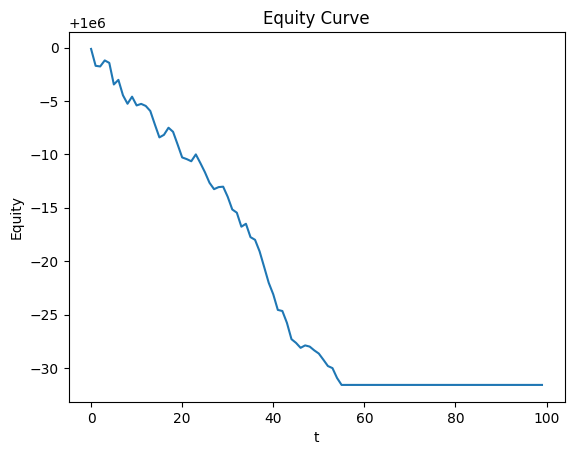

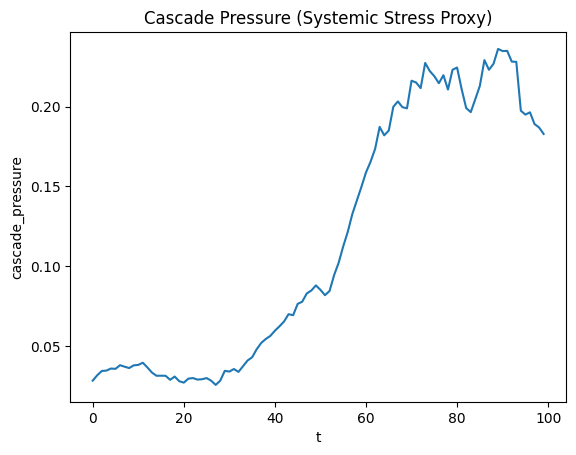

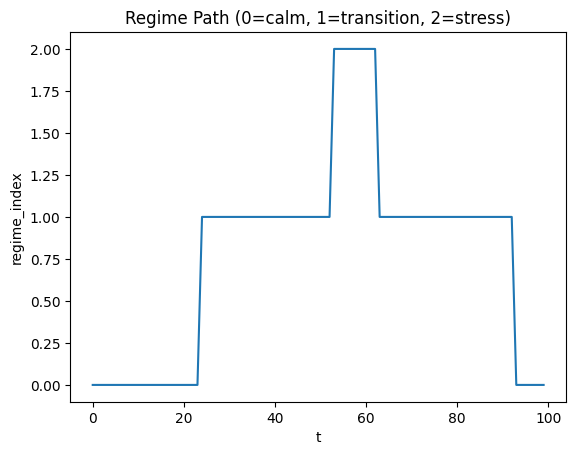

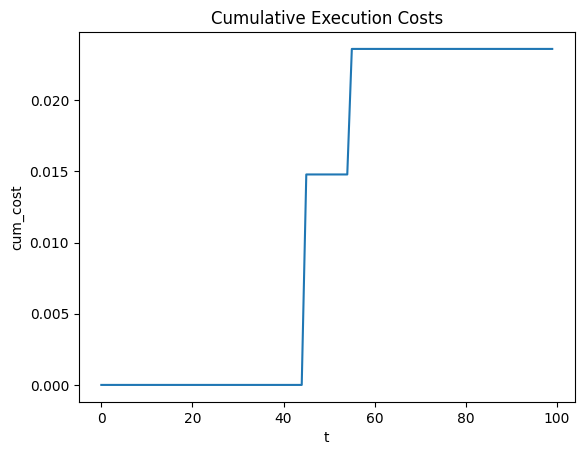

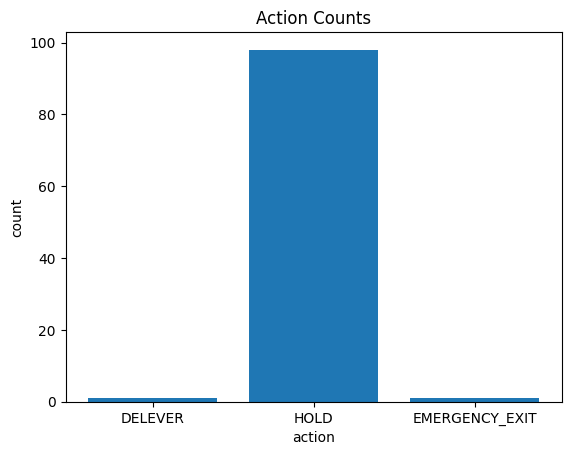

INTERPRETIVE TABLE (MECHANISM LAB LESSONS)


,mechanism,observation_in_logs,fragility,execution_note
0,Funding stress + tighter margins raise forced ...,"funding_rate ↑, margin_tight ↑ coincident with...",Constraint binding replaces optimization; smal...,Costs become endogenous: slippage grows with c...
1,Network contagion transmits distress via expos...,avg_distress and max_distress rise with insolv...,Diversification across institutions collapses ...,Liquidity vanishes when everyone sells; 'exiti...
2,Forced sales create price impact feedback (fir...,impact_component becomes negative as cascade_p...,Endogenous volatility: sales cause drops that ...,Turnover is penalized exactly in stress—surviv...
3,Survival dominates optimization under drawdown...,stop_flag triggers; position collapses to ~0 t...,"State space truncates: once stopped, strategy ...","Risk kill-switch is a governance feature, not ..."


Saved: chapter10_artifacts.json, chapter10_step_logs.csv, chapter10_llm_telemetry.csv


In [23]:
# CELL 10 — Code
# Diagnostics + interpretive table (plots + action counts + summary metrics + mechanism table)

def max_drawdown(equity: np.ndarray) -> float:
    peak = np.maximum.accumulate(equity)
    dd = (peak - equity) / np.maximum(peak, 1e-12)
    return float(dd.max())

def annualized_vol(returns: np.ndarray, periods_per_year: int = 252) -> float:
    return float(np.std(returns) * math.sqrt(periods_per_year))

def sharpe_like(returns: np.ndarray, periods_per_year: int = 252) -> float:
    mu = float(np.mean(returns) * periods_per_year)
    sd = annualized_vol(returns, periods_per_year)
    return float(mu / (sd + 1e-12))

# --- Core series ---
eq = logs["equity"].to_numpy()
px = logs["price"].to_numpy()
cost = logs["cost"].to_numpy()
cp = logs["cascade_pressure"].to_numpy()
reg = logs["regime"].to_numpy()

ret = np.diff(eq) / np.maximum(eq[:-1], 1e-12)
tot_ret = float(eq[-1] / eq[0] - 1.0)
mdd = max_drawdown(eq)
vol = annualized_vol(ret)
sr = sharpe_like(ret)

turnover = float(np.mean(np.abs(logs["trade"].to_numpy())))
cost_ratio = float(logs["cum_cost"].iloc[-1] / max(eq[0], 1e-12))
stress_frac = float(np.mean(reg == "stress"))
llm_ok = float(llm_df["ok"].mean()) if len(llm_df) else np.nan
llm_latency = float(llm_df["latency_ms"].mean()) if len(llm_df) else np.nan

# --- Action counts ---
action_counts = logs["action"].value_counts().reindex(ACTIONS).fillna(0).astype(int)

# --- Summary metrics table ---
summary = pd.DataFrame([
    {"metric": "Total return", "value": tot_ret},
    {"metric": "Max drawdown", "value": mdd},
    {"metric": "Ann. vol (equity)", "value": vol},
    {"metric": "Sharpe-like (synthetic)", "value": sr},
    {"metric": "Avg |trade|", "value": turnover},
    {"metric": "Cumulative cost / initial equity", "value": cost_ratio},
    {"metric": "Stress regime fraction", "value": stress_frac},
    {"metric": "LLM ok rate", "value": llm_ok},
    {"metric": "LLM mean latency (ms)", "value": llm_latency},
])

print("SUMMARY METRICS")
display(summary)

# --- Plots (matplotlib; no fixed colors) ---
plt.figure()
plt.plot(logs["t"], logs["equity"])
plt.title("Equity Curve")
plt.xlabel("t")
plt.ylabel("Equity")
plt.show()

plt.figure()
plt.plot(logs["t"], logs["cascade_pressure"])
plt.title("Cascade Pressure (Systemic Stress Proxy)")
plt.xlabel("t")
plt.ylabel("cascade_pressure")
plt.show()

# Regime plot: encode regimes as integers for visibility
reg_map = {"calm": 0, "transition": 1, "stress": 2}
reg_int = np.array([reg_map[x] for x in reg])
plt.figure()
plt.plot(logs["t"], reg_int)
plt.title("Regime Path (0=calm, 1=transition, 2=stress)")
plt.xlabel("t")
plt.ylabel("regime_index")
plt.show()

plt.figure()
plt.plot(logs["t"], logs["cum_cost"])
plt.title("Cumulative Execution Costs")
plt.xlabel("t")
plt.ylabel("cum_cost")
plt.show()

plt.figure()
plt.bar(action_counts.index, action_counts.values)
plt.title("Action Counts")
plt.xlabel("action")
plt.ylabel("count")
plt.show()

# --- Interpretive table (mechanism → observation → fragility → execution note) ---
interpretive = pd.DataFrame([
    {
        "mechanism": "Funding stress + tighter margins raise forced deleveraging propensity",
        "observation_in_logs": "funding_rate ↑, margin_tight ↑ coincident with action=DELEVER/EMERGENCY_EXIT",
        "fragility": "Constraint binding replaces optimization; small shocks trigger large inventory changes",
        "execution_note": "Costs become endogenous: slippage grows with cascade_pressure"
    },
    {
        "mechanism": "Network contagion transmits distress via exposure graph W",
        "observation_in_logs": "avg_distress and max_distress rise with insolvent_count; cascade_pressure spikes",
        "fragility": "Diversification across institutions collapses when balance sheets are linked",
        "execution_note": "Liquidity vanishes when everyone sells; 'exiting' is most expensive when most needed"
    },
    {
        "mechanism": "Forced sales create price impact feedback (fire-sale externality)",
        "observation_in_logs": "impact_component becomes negative as cascade_pressure rises; equity drawdowns accelerate",
        "fragility": "Endogenous volatility: sales cause drops that cause more sales",
        "execution_note": "Turnover is penalized exactly in stress—survival trades are not 'free'"
    },
    {
        "mechanism": "Survival dominates optimization under drawdown control",
        "observation_in_logs": "stop_flag triggers; position collapses to ~0 thereafter",
        "fragility": "State space truncates: once stopped, strategy space collapses to 'do nothing'",
        "execution_note": "Risk kill-switch is a governance feature, not an alpha feature"
    },
])

print("INTERPRETIVE TABLE (MECHANISM LAB LESSONS)")
display(interpretive)

# Optional: save artifacts locally (Colab runtime)
artifacts = {
    "run_manifest": run_manifest,
    "summary_metrics": summary.to_dict(orient="records"),
    "action_counts": action_counts.to_dict(),
    "verification_status": "Not verified"
}
with open("chapter10_artifacts.json", "w") as f:
    json.dump(artifacts, f, indent=2)

logs.to_csv("chapter10_step_logs.csv", index=False)
llm_df.to_csv("chapter10_llm_telemetry.csv", index=False)

print("Saved: chapter10_artifacts.json, chapter10_step_logs.csv, chapter10_llm_telemetry.csv")


##11.CONCLUSION

**Conclusion (Chapter 10 — Systemic Stress: Cascade Simulator)**

The cascade simulator closes the loop on the central promise of the mechanism-first series: a surface exists because a mechanism exists, the mechanism pays in calm and charges in stress, and the execution layer converts theoretical posture into realized fragility. Chapter 10 makes this promise uncomfortable in the most productive way. It demonstrates that when systemic constraints bind, the familiar language of “signals” and “views” becomes secondary. The binding constraint is financing. The state variable that matters is not primarily expected return; it is the ability to remain solvent while the market reprices your inventory and charges you for changing it.

The most important output of the notebook is not a performance line. It is a causal trace. When you examine the logs, you can see a structured progression: funding stress and margin tightness rise, distress accumulates across institutions, forced-sale pressure increases, price impact turns negative, and the portfolio’s equity falls both from mark-to-market losses and from the rising execution tax of de-risking. This is the signature of a cascade. What begins as a moderate shock becomes a nonlinear event because participants share constraints and because the market microstructure—modeled here through stress-sensitive impact—turns synchronized selling into self-reinforcing price declines.

This is why the “tradable surface” in this chapter is a balance-sheet object rather than a conventional price curve. The adjacency matrix of exposures, paired with distress metrics and cascade pressure, is tradable because it determines the marginal penalty of holding and adjusting risk. In a calm regime, that penalty is small and the same posture is feasible. In a stress regime, the penalty increases sharply, and the feasible set collapses. The surface thus governs not only payoffs but also the agent’s constraint set. In institutional terms, it governs the bindingness of risk limits, the likelihood of forced deleveraging, and the speed at which liquidity disappears. Reading this surface as an equilibrium object is the chapter’s conceptual achievement: the network is not an afterthought; it is the market’s hidden geometry.

The constrained action space reinforces that systemic trading is often a posture problem rather than a selection problem. The notebook is explicit: the agent may only choose `DELEVER`, `HOLD`, or `EMERGENCY_EXIT`. This is not a toy restriction. During cascades, real trading desks effectively face the same limited menu: reduce gross exposure, maintain and tolerate volatility, or cut risk aggressively at high cost. Once you accept that, the question becomes: how does one time these posture shifts when liquidity and impact are state-dependent? The baseline rule policy demonstrates a minimal, auditable answer: cut risk when systemic pressure breaches thresholds or when funding and margin conditions jointly signal a high probability of forced sales. The LLM policy, when enabled, demonstrates a governance-first integration of machine reasoning: the model is boxed into the action set, must output parseable JSON, and is forced to justify decisions briefly in mechanism-aware terms. If it fails, the system falls back automatically to baseline. This design is not merely safe; it mirrors institutional controls that exist precisely because decision-making systems fail under stress.

The diagnostic suite reinforces the same theme. The equity curve is best read as an indicator of constraint binding: steep drawdowns coincide with high cascade pressure and elevated impact. The regime plot serves as the map between state and feasibility: it shows when the environment shifts from “optimization-friendly” to “survival-dominant.” The cost accumulation plot quantifies a critical asymmetry: the more you need to trade, the more expensive trading becomes. Action counts provide an immediate test for robustness: if the policy thrashes, it will pay unnecessary costs; if it never exits, it will absorb nonlinear losses; if it exits too early, it will crystallize drawdowns and potentially miss recoveries. Summary metrics provide compact comparisons for controlled experimentation, but the interpretive table is the real conclusion: it forces you to articulate, explicitly, which mechanism produced which observation and how execution converted it into realized outcomes.

As a capstone, the cascade simulator also clarifies what the previous chapters were implicitly assuming. Yield-curve trades, carry trades, credit spread trades, volatility surface trades, and correlation-based posture choices all depend on the premise that positions can be adjusted without catastrophic costs before constraints bind. This chapter shows the failure mode of that premise. When the system enters a deleveraging spiral, the option to “rebalance” can become a fiction. The timing of hedges, the size of trades, and the relationship between inventory and liquidity become the dominant determinants of survival. In that regime, a strategy that is theoretically sound in expectation can be practically unsound because its path-dependent exposure to liquidity is fatal.

This is also where the series’ mechanism-first pedagogy proves its value. By building explicit economic dynamics—funding stress, margin tightness, leverage, network contagion, forced sales, and impact—you can run counterfactual experiments that would be ambiguous in purely statistical backtests. You can increase network density and observe how diversification collapses at the institution level. You can tighten margin and observe earlier, sharper cascades. You can raise impact sensitivity and observe that the same shock produces a materially worse drawdown. You can change regime persistence and observe how the frequency and duration of stress states alter survivability. These are not parameter fiddles for performance; they are structural perturbations to test fragility. That is the educational aim: to give the reader an experimental microscope for understanding systemic risk as an emergent property of constraints and coupling.

The notebook’s emphasis on auditability is not cosmetic and it is not optional. In professional environments, the most dangerous systems are those that cannot explain their own behavior. By logging state, surface summaries, actions, rationales, executed trades, costs, leverage usage, and PnL contributions at each step, the laboratory enforces a standard that is closer to institutional risk governance than to hobbyist backtesting. This matters especially for LLM integration. If an LLM is used, its decisions must be reproducible, bounded, and attributable. The fallback policy must be explicit. The telemetry must reveal whether the LLM is actually operating or whether the system is silently running baseline. In your own runs, the telemetry around errors and rationale constraints is itself a micro-lesson: governance controls are not abstract principles; they are engineering realities that determine whether an agentic loop is stable.

Where does this leave the broader project—market by market, notebook by notebook? Chapter 10 provides the stress-testing lens that should sit behind every other mechanism. It argues that every tradable surface—whether a curve, matrix, or tensor—should be paired with a “failure surface”: the constraint geometry that becomes dominant in stress. In practice, as you proceed through the collection and build notebooks across asset classes, you can use the cascade framework as a template for asking the right second-order question: what happens to this strategy when the system enters a regime where financing tightens, liquidity disappears, correlations compress, and participants are forced to sell together? Even if a chapter’s main surface is a yield curve or a volatility tensor, the systemic lens reminds you that the most important regimes are often those in which the surface is least stable and the act of trading against it is most costly.

The final takeaway is therefore not a trading rule but a structural mental model. Systemic stress is a constraint-driven phenomenon in which price is an output of balance-sheet mechanics. Forced deleveraging is not a tail anecdote; it is an endogenous possibility whenever leverage exists. Network linkages turn local shocks into systemic events by transmitting losses. Execution costs and impact are not small adjustments; in cascades they are central. In the limit, the correct objective function is not “maximize expected return” but “maximize survival probability subject to constraints,” because only survivors participate in the recovery. This chapter makes that statement operational in code and visible in diagnostics, and it provides the conceptual umbrella under which the rest of the mechanism-first series can be understood: the most important market structure is the structure that appears when things break.
